This tutorial is adapted from https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=ci-LpZWhRJoI by [Matthias Fey](https://rusty1s.github.io/#/)

In [1]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.0.0


## Installing dependencies

The installation of PyG on Colab can be a little bit tricky. Execute the cell below -- in case of issues, more information can be found on the [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html). 

_Note: This cell might take a while (up to ~10 minutes) to run_

In [2]:
# Install torch geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 25.5 MB/s eta 0:00:00


## Visualization

In [4]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

## Introduction

This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.

Let's dive into the world of GNNs by looking at a simple graph-structured example, the well-known [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.

## Dataset

PyTorch Geometric provides an easy access to the dataset via the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage:

In [1]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


After initializing the [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) dataset, we first can inspect some of its properties.
For example, we can see that this dataset holds exactly **one graph**, and that each node in this dataset is assigned a **34-dimensional feature vector** (which uniquely describes the members of the karate club).
Furthermore, the graph holds exactly **4 classes**, which represent the community each node belongs to.

Let's now look at the underlying graph in more detail:

In [2]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(2*data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 9.18
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Data

Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
We can print the data object anytime via `print(data)` to receive a short summary about its attributes and their shapes:
```
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```
We can see that this `data` object holds 4 attributes:
(1) The `edge_index` property holds the information about the **graph connectivity**, *i.e.*, a tuple of source and destination node indices for each edge.
PyG further refers to (2) **node features** as `x` (each of the 34 nodes is assigned a 34-dim feature vector), and to (3) **node labels** as `y` (each node is assigned to exactly one class).
(4) There also exists an additional attribute called `train_mask`, which describes for which nodes we already know their community assigments.
In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

The `data` object also provides some **utility functions** to infer some basic properties of the underlying graph.
For example, we can easily infer whether there exists isolated nodes in the graph (*i.e.* there exists no edge to any node), whether the graph contains self-loops (*i.e.*, $(v, v) \in \mathcal{E}$), or whether the graph is undirected (*i.e.*, for each edge $(v, w) \in \mathcal{E}$ there also exists the edge $(w, v) \in \mathcal{E}$).

In [5]:
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


## Edge Index

Next we'll print the `edge_index` of our graph:

In [6]:
#edge_index = data.edge_index
#print(edge_index.t())

By printing `edge_index`, we can further understand how PyG represents graph connectivity internally.
We can see that for each edge, `edge_index` holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.

This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

We can further visualize the graph by converting it to the `networkx` library format, which implements, in addition to graph manipulation functionalities, powerful tools for visualization:

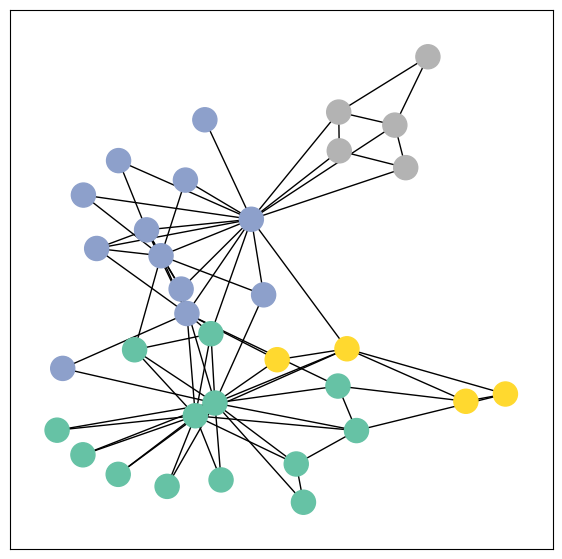

In [5]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

## Implementing Graph Neural Networks (GNNs)

Now, it's time to implement a Graph Neural Network!

For this, we will use one of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)).

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

### What is the output of a GNN?

The goal of a GNN is to take an input graph $G = (\mathcal{V}, \mathcal{E})$ where each node $v_i \in \mathcal{V}$ has an input feature vector $X_i^{(0)}$. What we want to learn is a function $f \to \mathcal{V} \times \mathcal{R}^d$, a function that takes in a node and its feature vector, as well as the graph structure, and outputs an _embedding_, a vector that represents that node in a way that's useful to our downstream task. Once we've mapped nodes and their initial features to their learned embeddings, we can use those embeddings to do a variety of different tasks including node-level, edge-level, or graph-level regression/classification.

In this colab, we want to learn embeddings that will be useful to classify each node into its community.

With this, we are ready to create our first Graph Neural Network by defining our network architecture in a `torch.nn.Module` class:

In [29]:
import torch
from torch.nn import Linear



import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class MyGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        #print(edge_index.size())
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        #print(edge_index.size())

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)

        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = torch.ones_like(deg_inv_sqrt[row] * deg_inv_sqrt[col])

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j


import torch
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.nn import MessagePassing


class MyEdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='max') #  "Max" aggregation.
        self.mlp = Seq(Linear(2 * in_channels, out_channels),
                       ReLU(),
                       Linear(out_channels, out_channels))

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        # x_i has shape [E, in_channels]
        # x_j has shape [E, in_channels]

        tmp = torch.cat([x_i, x_j - x_i], dim=1)  # tmp has shape [E, 2 * in_channels]
        return self.mlp(tmp)

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.classifier = Linear(4, dataset.num_classes)

        self.convs = torch.nn.ModuleList()

        self.convs.append(MyEdgeConv(34, 8))
        self.convs.append(MyEdgeConv(8, 4))
        self.convs.append(MyEdgeConv(4, 4))

        self.relu = torch.nn.ReLU()

    def forward(self, x, edge_index):

        for l in range(2):
          x = self.convs[l](x, edge_index)
          x = x.tanh()
    
        h = torch.nn.functional.dropout(x, p=0.5, training=self.training)
        h = self.convs[2](h, edge_index)
        embeddings = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(embeddings)

        return out, embeddings

model = GCN()
print(model)

GCN(
  (classifier): Linear(in_features=4, out_features=4, bias=True)
  (convs): ModuleList(
    (0-2): 3 x MyEdgeConv()
  )
  (relu): ReLU()
)


Here, we first initialize all of our building blocks in `__init__` and define the computation flow of our network in `forward`.
We first define and stack **three graph convolution layers**. Each layer corresponds to aggregating information from each node's 1-hop neighborhood (its direct neighbors), but when we compose the layers together, we are able to aggregate information from each node's 3-hop neighborhood (all nodes up to 3 "hops" away).

In addition, the `GCNConv` layers reduce the node feature dimensionality to $2$, *i.e.*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh) non-linearity.

After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.
We proceed to initialize our final model via `GCN()`, and printing our model produces a summary of all its used sub-modules.

Embedding shape: [34, 4]


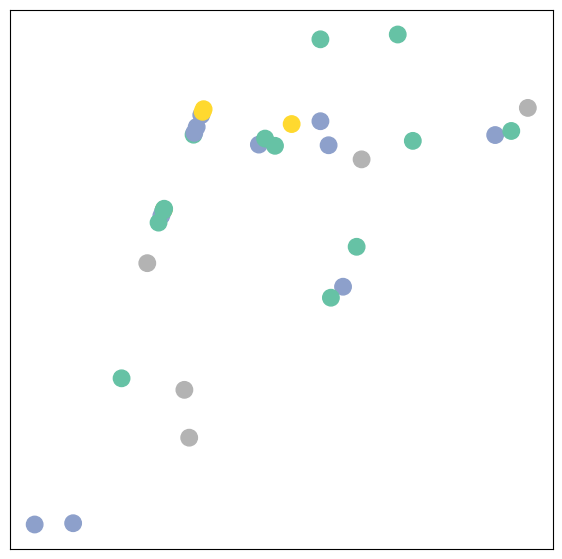

In [30]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.
Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

### Training on the Karate Club Network

But can we do better? Let's look at an example on how to train our network parameters based on the knowledge of the community assignments of 4 nodes in the graph (one for each community):

Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observe how the embeddings react.
Here, we make use of a semi-supervised or transductive learning procedure: We simply train against one node per class, but are allowed to make use of the complete input graph data.

Training our model is very similar to any other PyTorch model.
In addition to defining our network architecture, we define a loss critertion (here, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and initialize a stochastic gradient optimizer (here, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.
If you are not new to PyTorch, this scheme should appear familar to you. 
Otherwise, the PyTorch docs provide [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

Note that our semi-supervised learning scenario is achieved by the following line:
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.
Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

Let us now start training and see how our node embeddings evolve over time (best experienced by explicitely running the code):

tensor(1.4164, grad_fn=<NllLossBackward0>)


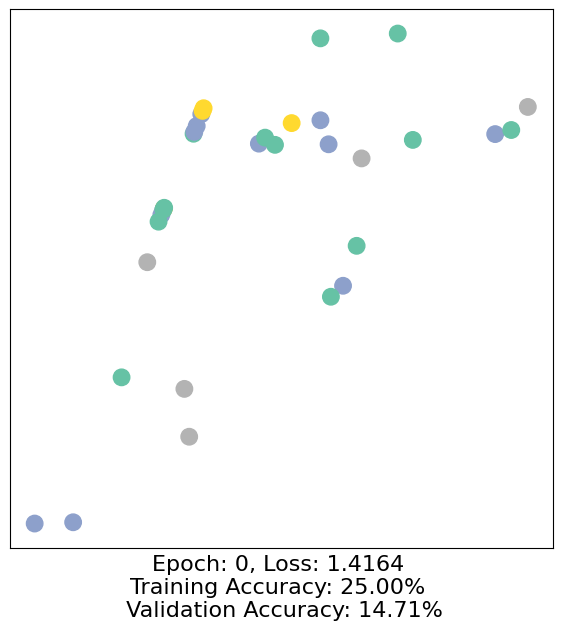

tensor(1.4028, grad_fn=<NllLossBackward0>)
tensor(1.4061, grad_fn=<NllLossBackward0>)
tensor(1.4081, grad_fn=<NllLossBackward0>)
tensor(1.4093, grad_fn=<NllLossBackward0>)
tensor(1.3993, grad_fn=<NllLossBackward0>)
tensor(1.4227, grad_fn=<NllLossBackward0>)
tensor(1.3817, grad_fn=<NllLossBackward0>)
tensor(1.3922, grad_fn=<NllLossBackward0>)
tensor(1.3981, grad_fn=<NllLossBackward0>)
tensor(1.3605, grad_fn=<NllLossBackward0>)


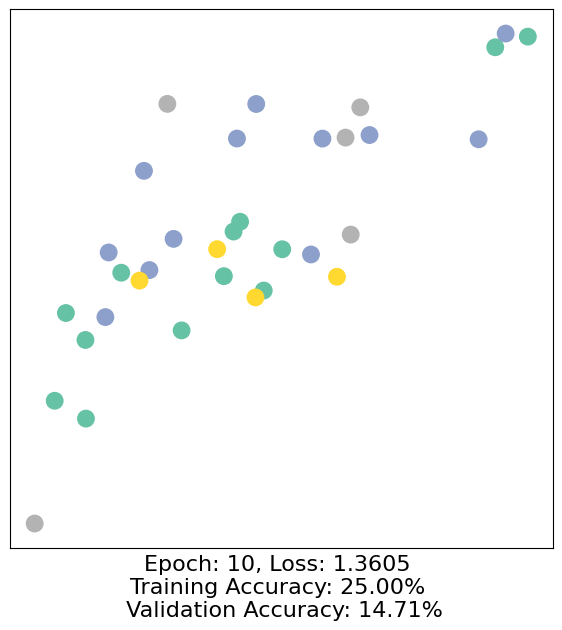

tensor(1.3562, grad_fn=<NllLossBackward0>)
tensor(1.3504, grad_fn=<NllLossBackward0>)
tensor(1.3674, grad_fn=<NllLossBackward0>)
tensor(1.3484, grad_fn=<NllLossBackward0>)
tensor(1.3445, grad_fn=<NllLossBackward0>)
tensor(1.3002, grad_fn=<NllLossBackward0>)
tensor(1.3089, grad_fn=<NllLossBackward0>)
tensor(1.3236, grad_fn=<NllLossBackward0>)
tensor(1.3098, grad_fn=<NllLossBackward0>)
tensor(1.2071, grad_fn=<NllLossBackward0>)


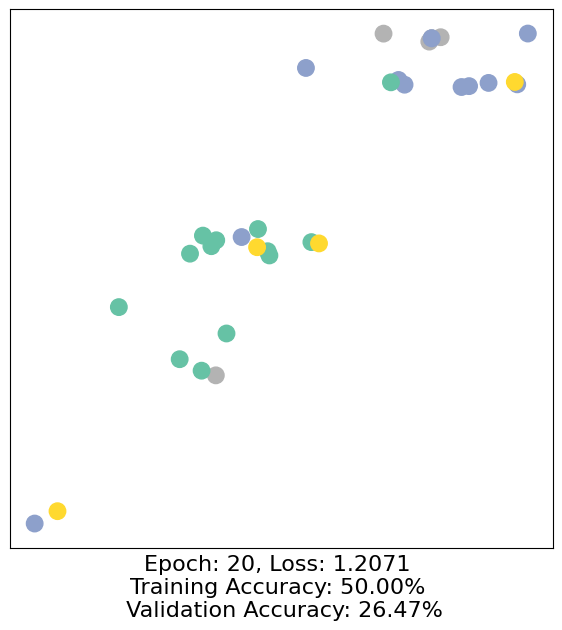

tensor(1.2360, grad_fn=<NllLossBackward0>)
tensor(1.1409, grad_fn=<NllLossBackward0>)
tensor(1.0667, grad_fn=<NllLossBackward0>)
tensor(1.0491, grad_fn=<NllLossBackward0>)
tensor(1.2055, grad_fn=<NllLossBackward0>)
tensor(1.0932, grad_fn=<NllLossBackward0>)
tensor(1.1555, grad_fn=<NllLossBackward0>)
tensor(0.9362, grad_fn=<NllLossBackward0>)
tensor(0.9064, grad_fn=<NllLossBackward0>)
tensor(1.0681, grad_fn=<NllLossBackward0>)


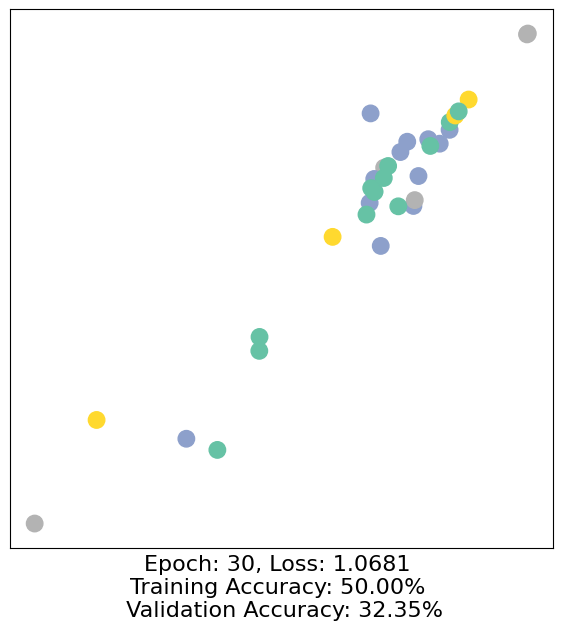

tensor(0.9789, grad_fn=<NllLossBackward0>)
tensor(0.8787, grad_fn=<NllLossBackward0>)
tensor(0.8975, grad_fn=<NllLossBackward0>)
tensor(0.8695, grad_fn=<NllLossBackward0>)
tensor(0.9019, grad_fn=<NllLossBackward0>)
tensor(0.9830, grad_fn=<NllLossBackward0>)
tensor(0.8498, grad_fn=<NllLossBackward0>)
tensor(0.8518, grad_fn=<NllLossBackward0>)
tensor(0.7898, grad_fn=<NllLossBackward0>)
tensor(0.9700, grad_fn=<NllLossBackward0>)


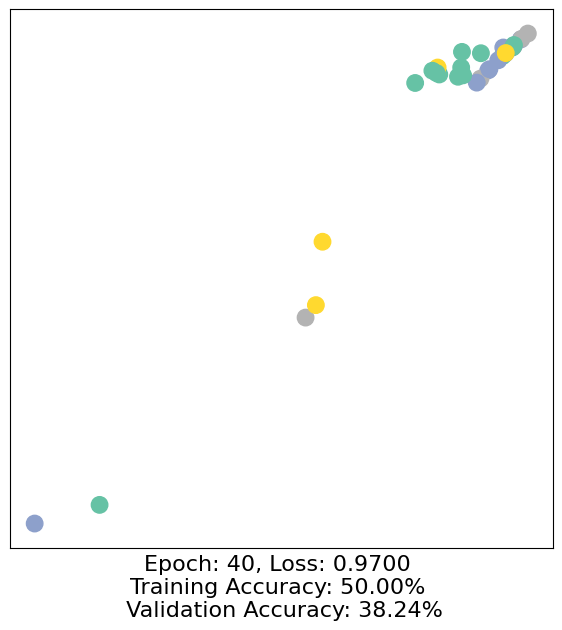

tensor(0.7990, grad_fn=<NllLossBackward0>)
tensor(0.9169, grad_fn=<NllLossBackward0>)
tensor(0.9011, grad_fn=<NllLossBackward0>)
tensor(0.7827, grad_fn=<NllLossBackward0>)
tensor(0.7875, grad_fn=<NllLossBackward0>)
tensor(0.8041, grad_fn=<NllLossBackward0>)
tensor(0.7763, grad_fn=<NllLossBackward0>)
tensor(0.7470, grad_fn=<NllLossBackward0>)
tensor(0.7487, grad_fn=<NllLossBackward0>)
tensor(0.7203, grad_fn=<NllLossBackward0>)


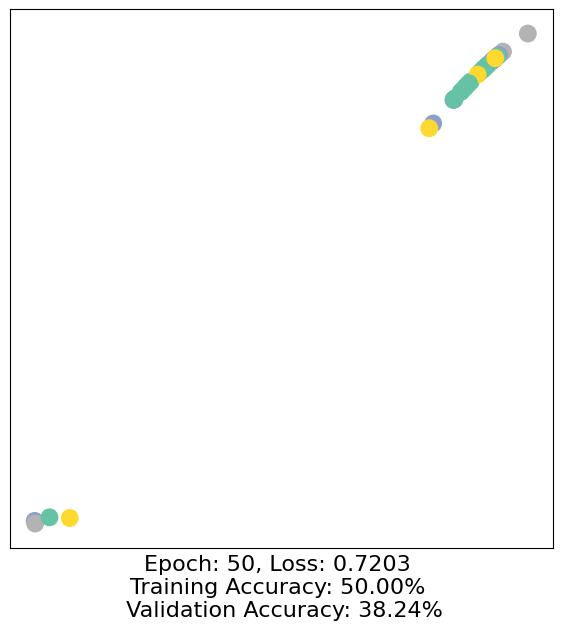

tensor(0.7228, grad_fn=<NllLossBackward0>)
tensor(0.7485, grad_fn=<NllLossBackward0>)
tensor(0.7222, grad_fn=<NllLossBackward0>)
tensor(0.7031, grad_fn=<NllLossBackward0>)
tensor(0.7162, grad_fn=<NllLossBackward0>)
tensor(0.9591, grad_fn=<NllLossBackward0>)
tensor(0.8117, grad_fn=<NllLossBackward0>)
tensor(0.6691, grad_fn=<NllLossBackward0>)
tensor(0.6606, grad_fn=<NllLossBackward0>)
tensor(0.6472, grad_fn=<NllLossBackward0>)


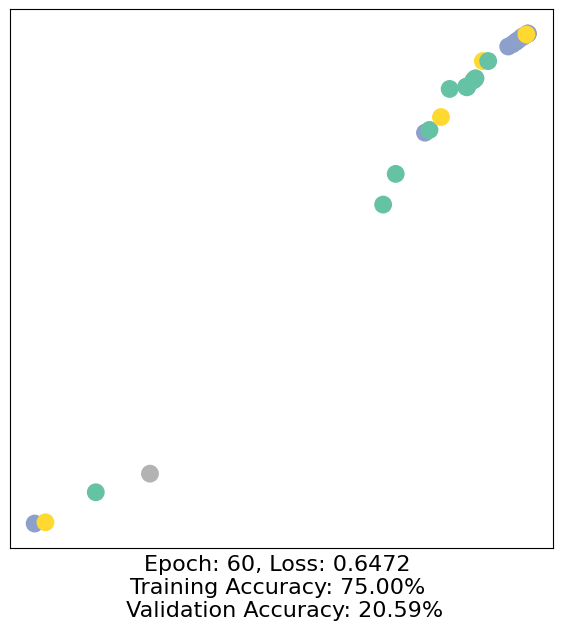

tensor(1.2239, grad_fn=<NllLossBackward0>)
tensor(0.6933, grad_fn=<NllLossBackward0>)
tensor(0.6453, grad_fn=<NllLossBackward0>)
tensor(0.6255, grad_fn=<NllLossBackward0>)
tensor(0.6204, grad_fn=<NllLossBackward0>)
tensor(0.6697, grad_fn=<NllLossBackward0>)
tensor(0.6295, grad_fn=<NllLossBackward0>)
tensor(0.6028, grad_fn=<NllLossBackward0>)
tensor(0.6309, grad_fn=<NllLossBackward0>)
tensor(0.8313, grad_fn=<NllLossBackward0>)


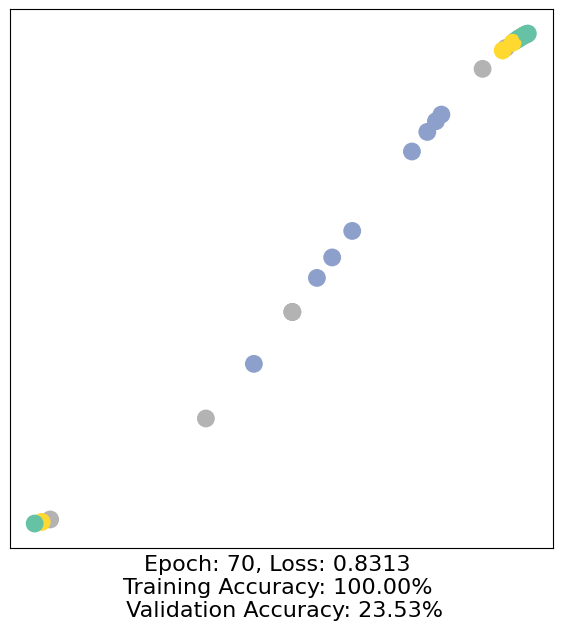

tensor(0.6084, grad_fn=<NllLossBackward0>)
tensor(0.5711, grad_fn=<NllLossBackward0>)
tensor(0.6094, grad_fn=<NllLossBackward0>)
tensor(0.6675, grad_fn=<NllLossBackward0>)
tensor(0.7058, grad_fn=<NllLossBackward0>)
tensor(0.5944, grad_fn=<NllLossBackward0>)
tensor(0.5838, grad_fn=<NllLossBackward0>)
tensor(0.5727, grad_fn=<NllLossBackward0>)
tensor(0.5499, grad_fn=<NllLossBackward0>)
tensor(0.5749, grad_fn=<NllLossBackward0>)


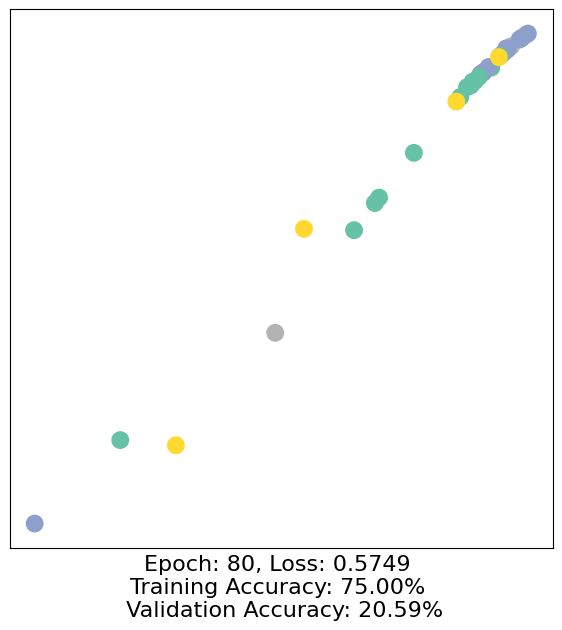

tensor(0.7051, grad_fn=<NllLossBackward0>)
tensor(0.5410, grad_fn=<NllLossBackward0>)
tensor(0.5347, grad_fn=<NllLossBackward0>)
tensor(0.5245, grad_fn=<NllLossBackward0>)
tensor(0.5384, grad_fn=<NllLossBackward0>)
tensor(0.5379, grad_fn=<NllLossBackward0>)
tensor(0.5199, grad_fn=<NllLossBackward0>)
tensor(0.5304, grad_fn=<NllLossBackward0>)
tensor(0.5216, grad_fn=<NllLossBackward0>)
tensor(0.5587, grad_fn=<NllLossBackward0>)


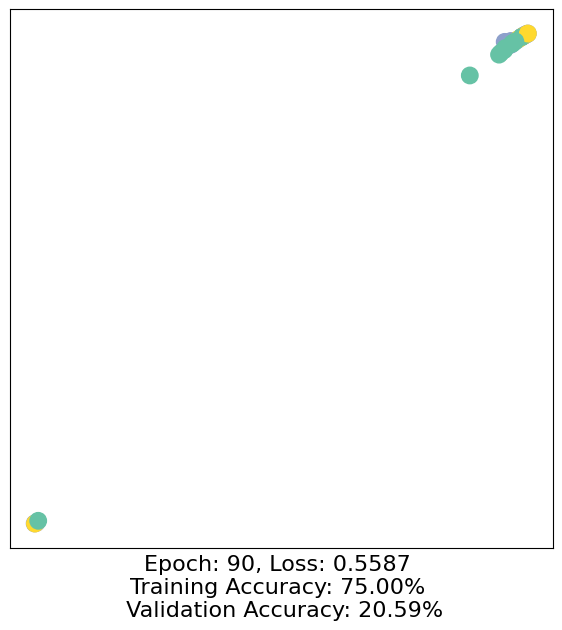

tensor(0.4933, grad_fn=<NllLossBackward0>)
tensor(0.4918, grad_fn=<NllLossBackward0>)
tensor(0.4913, grad_fn=<NllLossBackward0>)
tensor(0.4858, grad_fn=<NllLossBackward0>)
tensor(0.4802, grad_fn=<NllLossBackward0>)
tensor(0.4918, grad_fn=<NllLossBackward0>)
tensor(0.4817, grad_fn=<NllLossBackward0>)
tensor(0.4736, grad_fn=<NllLossBackward0>)
tensor(0.4907, grad_fn=<NllLossBackward0>)
tensor(0.4742, grad_fn=<NllLossBackward0>)


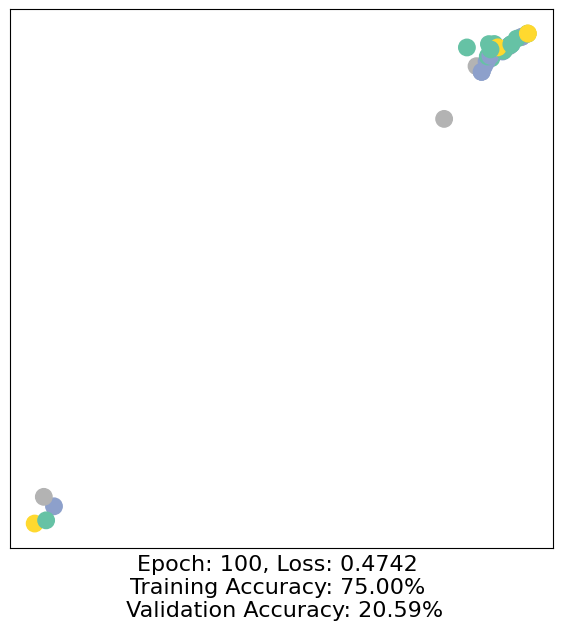

tensor(0.4717, grad_fn=<NllLossBackward0>)
tensor(0.4705, grad_fn=<NllLossBackward0>)
tensor(0.4857, grad_fn=<NllLossBackward0>)
tensor(0.4635, grad_fn=<NllLossBackward0>)
tensor(0.4609, grad_fn=<NllLossBackward0>)
tensor(0.4687, grad_fn=<NllLossBackward0>)
tensor(0.7194, grad_fn=<NllLossBackward0>)
tensor(0.4496, grad_fn=<NllLossBackward0>)
tensor(0.4647, grad_fn=<NllLossBackward0>)
tensor(0.4388, grad_fn=<NllLossBackward0>)


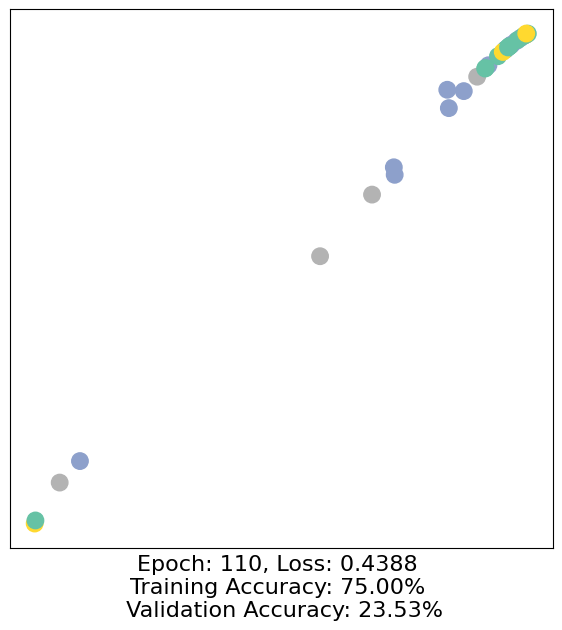

tensor(0.4515, grad_fn=<NllLossBackward0>)
tensor(0.4449, grad_fn=<NllLossBackward0>)
tensor(0.4429, grad_fn=<NllLossBackward0>)
tensor(0.4662, grad_fn=<NllLossBackward0>)
tensor(0.7625, grad_fn=<NllLossBackward0>)
tensor(0.4452, grad_fn=<NllLossBackward0>)
tensor(0.4364, grad_fn=<NllLossBackward0>)
tensor(0.4481, grad_fn=<NllLossBackward0>)
tensor(0.4449, grad_fn=<NllLossBackward0>)
tensor(0.4239, grad_fn=<NllLossBackward0>)


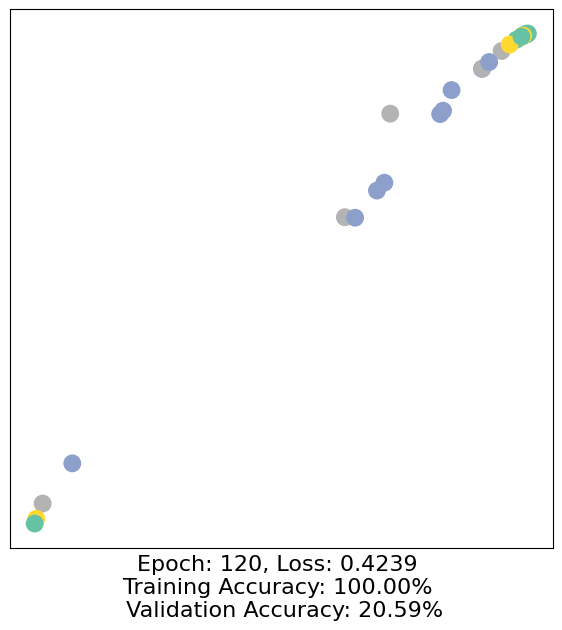

tensor(0.4331, grad_fn=<NllLossBackward0>)
tensor(0.4348, grad_fn=<NllLossBackward0>)
tensor(0.4275, grad_fn=<NllLossBackward0>)
tensor(0.4242, grad_fn=<NllLossBackward0>)
tensor(0.4239, grad_fn=<NllLossBackward0>)
tensor(0.4266, grad_fn=<NllLossBackward0>)
tensor(0.4067, grad_fn=<NllLossBackward0>)
tensor(0.4198, grad_fn=<NllLossBackward0>)
tensor(0.4220, grad_fn=<NllLossBackward0>)
tensor(0.4164, grad_fn=<NllLossBackward0>)


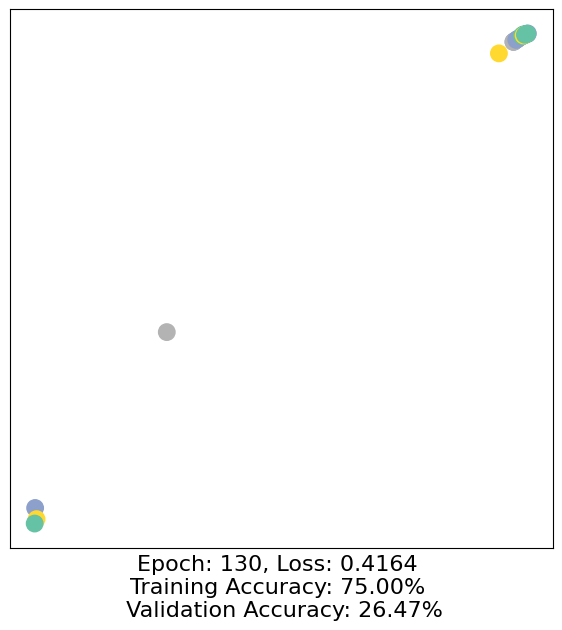

tensor(0.4120, grad_fn=<NllLossBackward0>)
tensor(0.4253, grad_fn=<NllLossBackward0>)
tensor(0.4270, grad_fn=<NllLossBackward0>)
tensor(0.4141, grad_fn=<NllLossBackward0>)
tensor(0.4063, grad_fn=<NllLossBackward0>)
tensor(0.3871, grad_fn=<NllLossBackward0>)
tensor(0.3894, grad_fn=<NllLossBackward0>)
tensor(0.3904, grad_fn=<NllLossBackward0>)
tensor(0.4263, grad_fn=<NllLossBackward0>)
tensor(0.4134, grad_fn=<NllLossBackward0>)


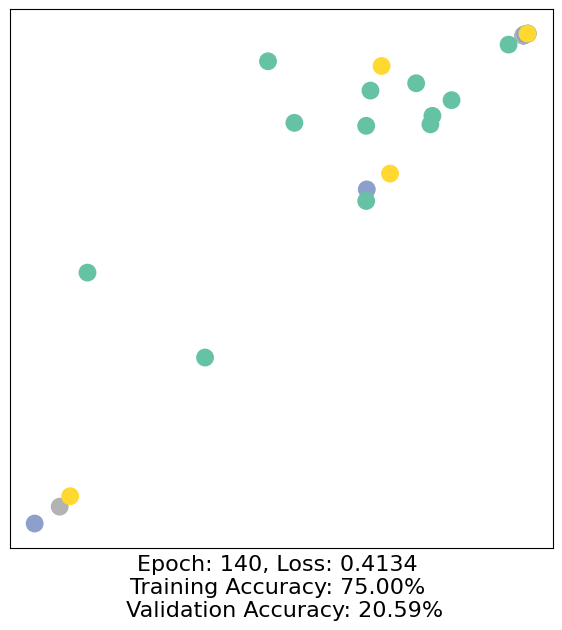

tensor(0.4294, grad_fn=<NllLossBackward0>)
tensor(0.9413, grad_fn=<NllLossBackward0>)
tensor(0.3611, grad_fn=<NllLossBackward0>)
tensor(1.3309, grad_fn=<NllLossBackward0>)
tensor(0.7857, grad_fn=<NllLossBackward0>)
tensor(0.3396, grad_fn=<NllLossBackward0>)
tensor(0.4280, grad_fn=<NllLossBackward0>)
tensor(0.4180, grad_fn=<NllLossBackward0>)
tensor(0.4397, grad_fn=<NllLossBackward0>)
tensor(0.3591, grad_fn=<NllLossBackward0>)


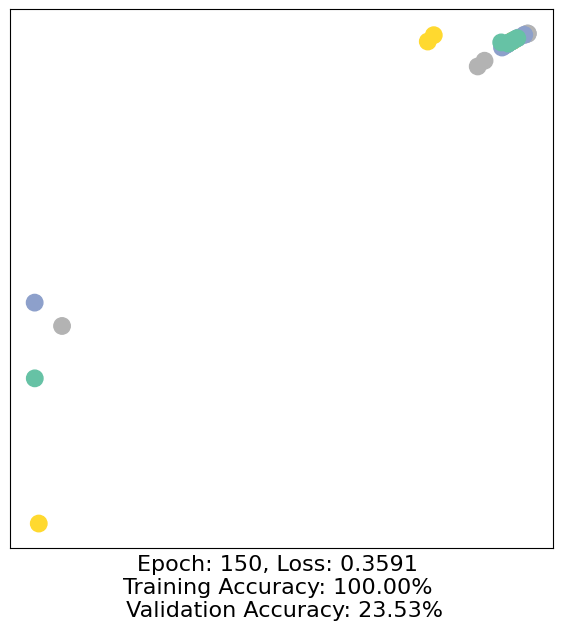

tensor(0.3465, grad_fn=<NllLossBackward0>)
tensor(0.4122, grad_fn=<NllLossBackward0>)
tensor(0.8451, grad_fn=<NllLossBackward0>)
tensor(0.4565, grad_fn=<NllLossBackward0>)
tensor(0.4214, grad_fn=<NllLossBackward0>)
tensor(0.4010, grad_fn=<NllLossBackward0>)
tensor(0.3047, grad_fn=<NllLossBackward0>)
tensor(0.4153, grad_fn=<NllLossBackward0>)
tensor(0.4268, grad_fn=<NllLossBackward0>)
tensor(0.4135, grad_fn=<NllLossBackward0>)


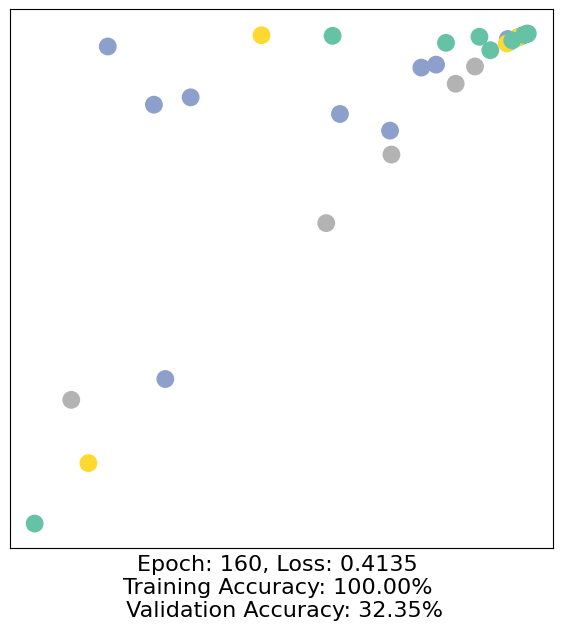

tensor(0.2891, grad_fn=<NllLossBackward0>)
tensor(0.4197, grad_fn=<NllLossBackward0>)
tensor(0.3479, grad_fn=<NllLossBackward0>)
tensor(0.4616, grad_fn=<NllLossBackward0>)
tensor(0.4452, grad_fn=<NllLossBackward0>)
tensor(0.3917, grad_fn=<NllLossBackward0>)
tensor(0.3934, grad_fn=<NllLossBackward0>)
tensor(0.2677, grad_fn=<NllLossBackward0>)
tensor(0.3242, grad_fn=<NllLossBackward0>)
tensor(0.2535, grad_fn=<NllLossBackward0>)


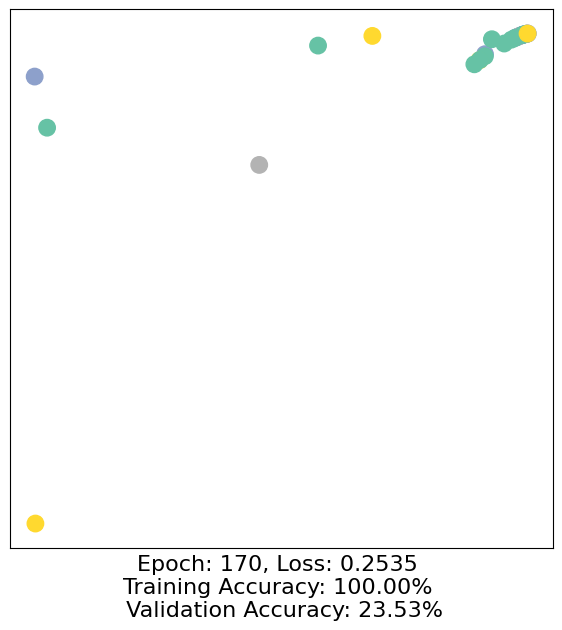

tensor(0.3143, grad_fn=<NllLossBackward0>)
tensor(0.2585, grad_fn=<NllLossBackward0>)
tensor(0.4345, grad_fn=<NllLossBackward0>)
tensor(0.4351, grad_fn=<NllLossBackward0>)
tensor(0.3990, grad_fn=<NllLossBackward0>)
tensor(0.2506, grad_fn=<NllLossBackward0>)
tensor(0.3376, grad_fn=<NllLossBackward0>)
tensor(0.3838, grad_fn=<NllLossBackward0>)
tensor(0.2332, grad_fn=<NllLossBackward0>)
tensor(0.4936, grad_fn=<NllLossBackward0>)


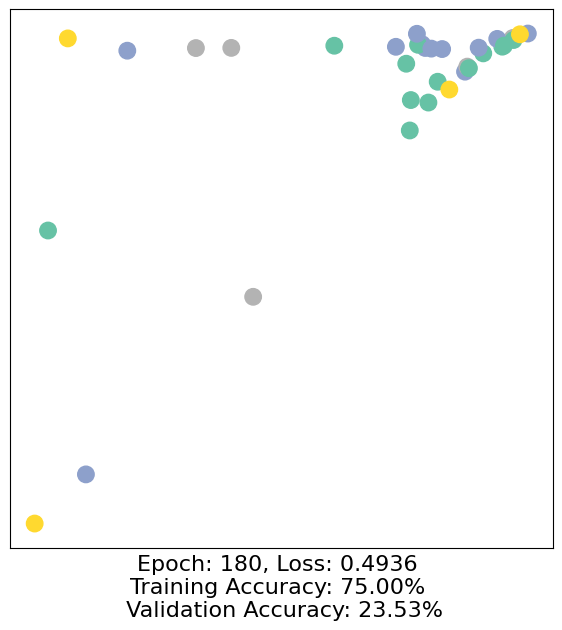

tensor(0.3744, grad_fn=<NllLossBackward0>)
tensor(0.2653, grad_fn=<NllLossBackward0>)
tensor(0.2271, grad_fn=<NllLossBackward0>)
tensor(0.5282, grad_fn=<NllLossBackward0>)
tensor(0.2143, grad_fn=<NllLossBackward0>)
tensor(0.7470, grad_fn=<NllLossBackward0>)
tensor(0.2805, grad_fn=<NllLossBackward0>)
tensor(0.2260, grad_fn=<NllLossBackward0>)
tensor(0.2852, grad_fn=<NllLossBackward0>)
tensor(0.2139, grad_fn=<NllLossBackward0>)


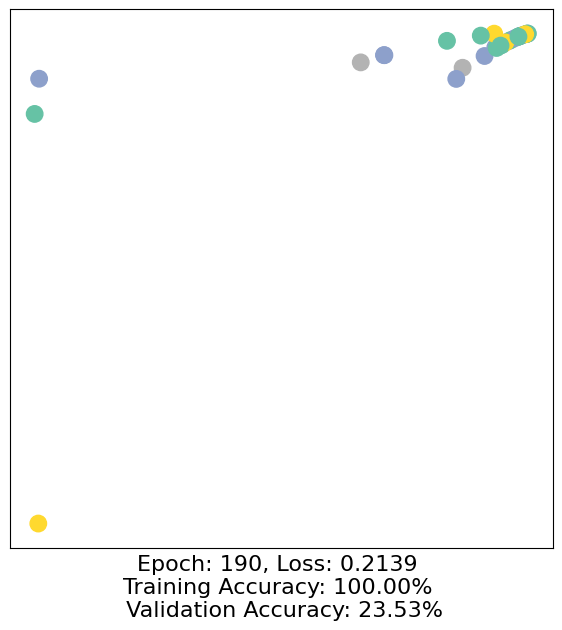

tensor(0.3302, grad_fn=<NllLossBackward0>)
tensor(0.2761, grad_fn=<NllLossBackward0>)
tensor(0.3646, grad_fn=<NllLossBackward0>)
tensor(0.2626, grad_fn=<NllLossBackward0>)
tensor(0.3121, grad_fn=<NllLossBackward0>)
tensor(0.3876, grad_fn=<NllLossBackward0>)
tensor(0.2064, grad_fn=<NllLossBackward0>)
tensor(0.4404, grad_fn=<NllLossBackward0>)
tensor(0.1700, grad_fn=<NllLossBackward0>)
tensor(0.2620, grad_fn=<NllLossBackward0>)


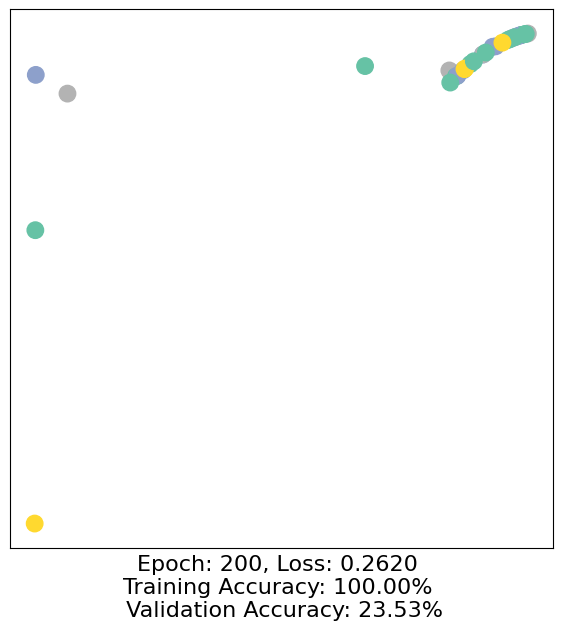

tensor(0.1920, grad_fn=<NllLossBackward0>)
tensor(0.2003, grad_fn=<NllLossBackward0>)
tensor(0.1565, grad_fn=<NllLossBackward0>)
tensor(0.1928, grad_fn=<NllLossBackward0>)
tensor(0.4353, grad_fn=<NllLossBackward0>)
tensor(0.1973, grad_fn=<NllLossBackward0>)
tensor(0.2852, grad_fn=<NllLossBackward0>)
tensor(0.2780, grad_fn=<NllLossBackward0>)
tensor(0.3387, grad_fn=<NllLossBackward0>)
tensor(0.2203, grad_fn=<NllLossBackward0>)


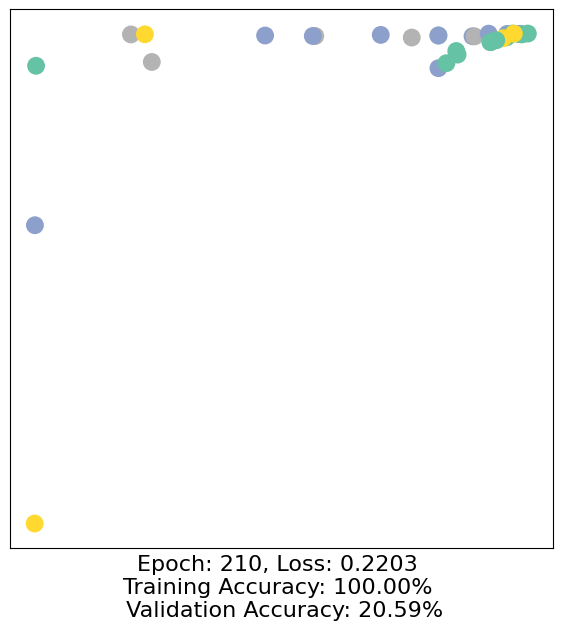

tensor(0.1420, grad_fn=<NllLossBackward0>)
tensor(0.1397, grad_fn=<NllLossBackward0>)
tensor(0.3608, grad_fn=<NllLossBackward0>)
tensor(0.1704, grad_fn=<NllLossBackward0>)
tensor(0.4286, grad_fn=<NllLossBackward0>)
tensor(0.1429, grad_fn=<NllLossBackward0>)
tensor(0.1389, grad_fn=<NllLossBackward0>)
tensor(0.2476, grad_fn=<NllLossBackward0>)
tensor(0.1623, grad_fn=<NllLossBackward0>)
tensor(0.8095, grad_fn=<NllLossBackward0>)


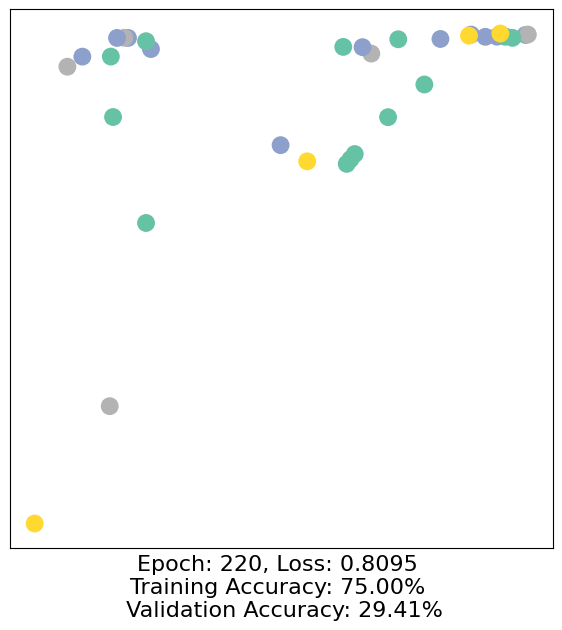

tensor(0.3031, grad_fn=<NllLossBackward0>)
tensor(0.1733, grad_fn=<NllLossBackward0>)
tensor(0.1244, grad_fn=<NllLossBackward0>)
tensor(0.1291, grad_fn=<NllLossBackward0>)
tensor(0.1889, grad_fn=<NllLossBackward0>)
tensor(0.5896, grad_fn=<NllLossBackward0>)
tensor(0.4207, grad_fn=<NllLossBackward0>)
tensor(0.1550, grad_fn=<NllLossBackward0>)
tensor(0.1310, grad_fn=<NllLossBackward0>)
tensor(0.1264, grad_fn=<NllLossBackward0>)


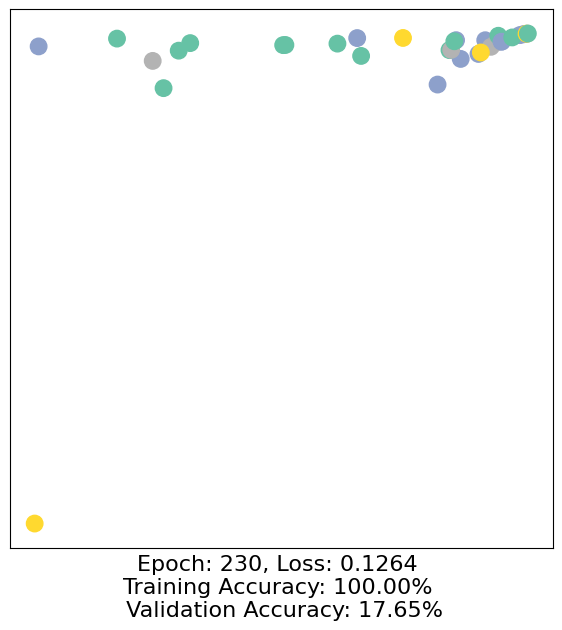

tensor(0.2514, grad_fn=<NllLossBackward0>)
tensor(0.1637, grad_fn=<NllLossBackward0>)
tensor(0.1318, grad_fn=<NllLossBackward0>)
tensor(0.1199, grad_fn=<NllLossBackward0>)
tensor(0.1875, grad_fn=<NllLossBackward0>)
tensor(0.1036, grad_fn=<NllLossBackward0>)
tensor(0.1115, grad_fn=<NllLossBackward0>)
tensor(0.1046, grad_fn=<NllLossBackward0>)
tensor(0.6371, grad_fn=<NllLossBackward0>)
tensor(0.1930, grad_fn=<NllLossBackward0>)


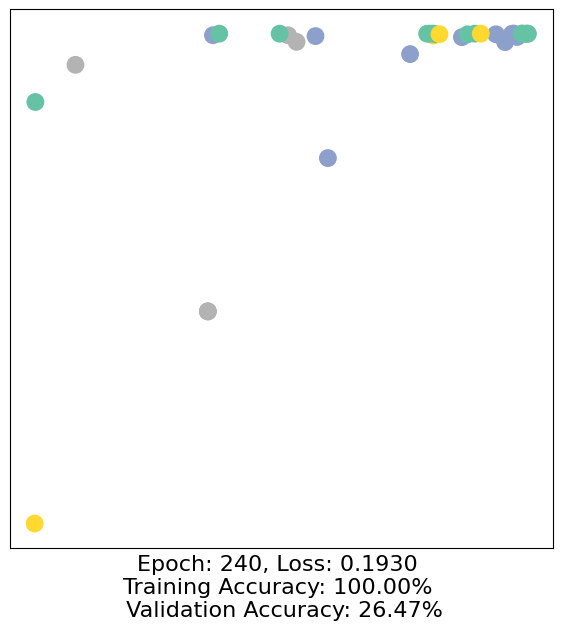

tensor(0.0987, grad_fn=<NllLossBackward0>)
tensor(0.1104, grad_fn=<NllLossBackward0>)
tensor(0.3446, grad_fn=<NllLossBackward0>)
tensor(0.3939, grad_fn=<NllLossBackward0>)
tensor(0.1956, grad_fn=<NllLossBackward0>)
tensor(0.1578, grad_fn=<NllLossBackward0>)
tensor(0.0920, grad_fn=<NllLossBackward0>)
tensor(0.0949, grad_fn=<NllLossBackward0>)
tensor(0.1600, grad_fn=<NllLossBackward0>)
tensor(0.1059, grad_fn=<NllLossBackward0>)


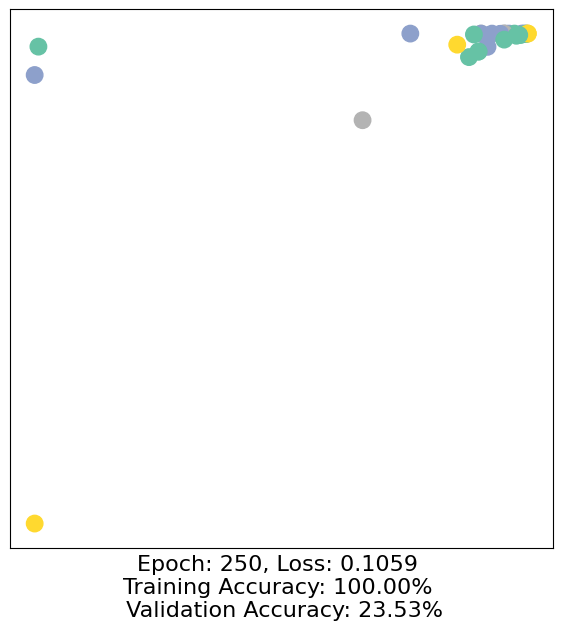

tensor(0.2771, grad_fn=<NllLossBackward0>)
tensor(0.1426, grad_fn=<NllLossBackward0>)
tensor(0.8489, grad_fn=<NllLossBackward0>)
tensor(0.2046, grad_fn=<NllLossBackward0>)
tensor(1.1965, grad_fn=<NllLossBackward0>)
tensor(0.0873, grad_fn=<NllLossBackward0>)
tensor(0.0798, grad_fn=<NllLossBackward0>)
tensor(0.0824, grad_fn=<NllLossBackward0>)
tensor(0.0986, grad_fn=<NllLossBackward0>)
tensor(0.1449, grad_fn=<NllLossBackward0>)


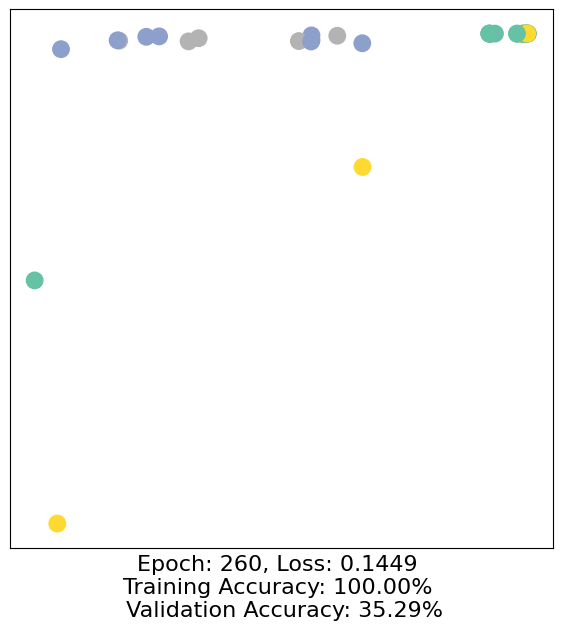

tensor(0.1541, grad_fn=<NllLossBackward0>)
tensor(0.1415, grad_fn=<NllLossBackward0>)
tensor(0.1394, grad_fn=<NllLossBackward0>)
tensor(0.4132, grad_fn=<NllLossBackward0>)
tensor(0.0916, grad_fn=<NllLossBackward0>)
tensor(0.1223, grad_fn=<NllLossBackward0>)
tensor(0.0820, grad_fn=<NllLossBackward0>)
tensor(0.1009, grad_fn=<NllLossBackward0>)
tensor(0.1116, grad_fn=<NllLossBackward0>)
tensor(0.0859, grad_fn=<NllLossBackward0>)


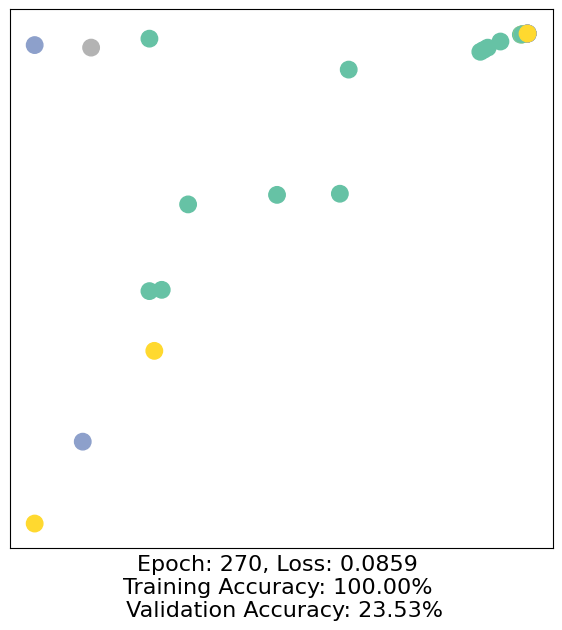

tensor(0.0829, grad_fn=<NllLossBackward0>)
tensor(0.0974, grad_fn=<NllLossBackward0>)
tensor(0.0885, grad_fn=<NllLossBackward0>)
tensor(0.0794, grad_fn=<NllLossBackward0>)
tensor(0.0814, grad_fn=<NllLossBackward0>)
tensor(0.0746, grad_fn=<NllLossBackward0>)
tensor(0.0716, grad_fn=<NllLossBackward0>)
tensor(0.1115, grad_fn=<NllLossBackward0>)
tensor(0.1160, grad_fn=<NllLossBackward0>)
tensor(0.0817, grad_fn=<NllLossBackward0>)


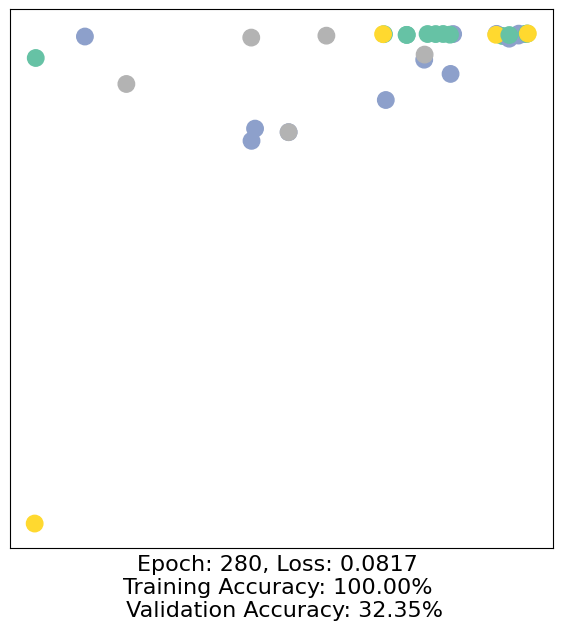

tensor(0.0930, grad_fn=<NllLossBackward0>)
tensor(0.0989, grad_fn=<NllLossBackward0>)
tensor(0.0728, grad_fn=<NllLossBackward0>)
tensor(0.0768, grad_fn=<NllLossBackward0>)
tensor(0.0773, grad_fn=<NllLossBackward0>)
tensor(0.0899, grad_fn=<NllLossBackward0>)
tensor(0.1343, grad_fn=<NllLossBackward0>)
tensor(0.3880, grad_fn=<NllLossBackward0>)
tensor(0.0928, grad_fn=<NllLossBackward0>)
tensor(0.0668, grad_fn=<NllLossBackward0>)


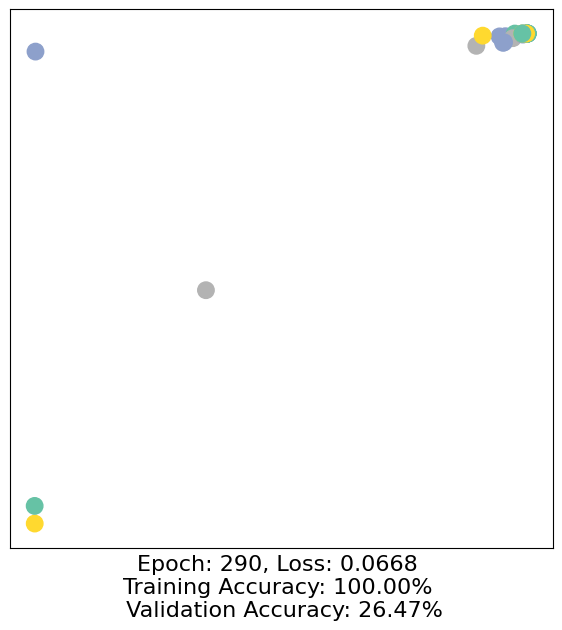

tensor(0.0865, grad_fn=<NllLossBackward0>)
tensor(0.0626, grad_fn=<NllLossBackward0>)
tensor(0.6632, grad_fn=<NllLossBackward0>)
tensor(0.0649, grad_fn=<NllLossBackward0>)
tensor(0.2336, grad_fn=<NllLossBackward0>)
tensor(0.0632, grad_fn=<NllLossBackward0>)
tensor(0.0878, grad_fn=<NllLossBackward0>)
tensor(0.0628, grad_fn=<NllLossBackward0>)
tensor(0.1037, grad_fn=<NllLossBackward0>)
tensor(0.0919, grad_fn=<NllLossBackward0>)


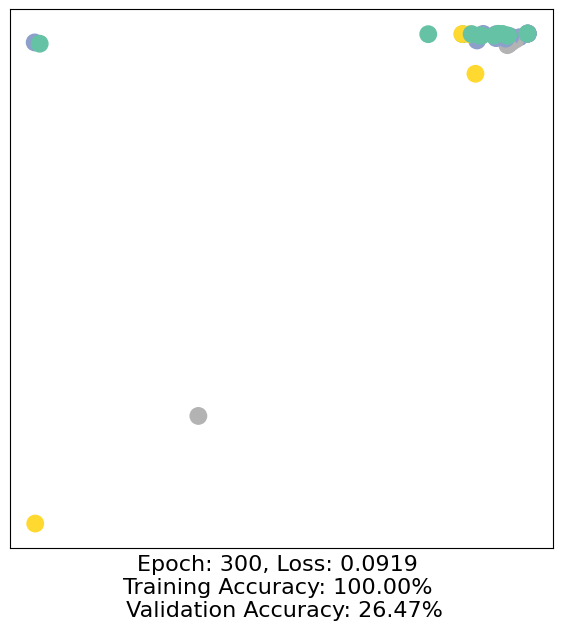

tensor(0.0797, grad_fn=<NllLossBackward0>)
tensor(0.1493, grad_fn=<NllLossBackward0>)
tensor(0.0612, grad_fn=<NllLossBackward0>)
tensor(0.0567, grad_fn=<NllLossBackward0>)
tensor(0.1567, grad_fn=<NllLossBackward0>)
tensor(0.0564, grad_fn=<NllLossBackward0>)
tensor(0.0612, grad_fn=<NllLossBackward0>)
tensor(0.0663, grad_fn=<NllLossBackward0>)
tensor(0.0640, grad_fn=<NllLossBackward0>)
tensor(0.0814, grad_fn=<NllLossBackward0>)


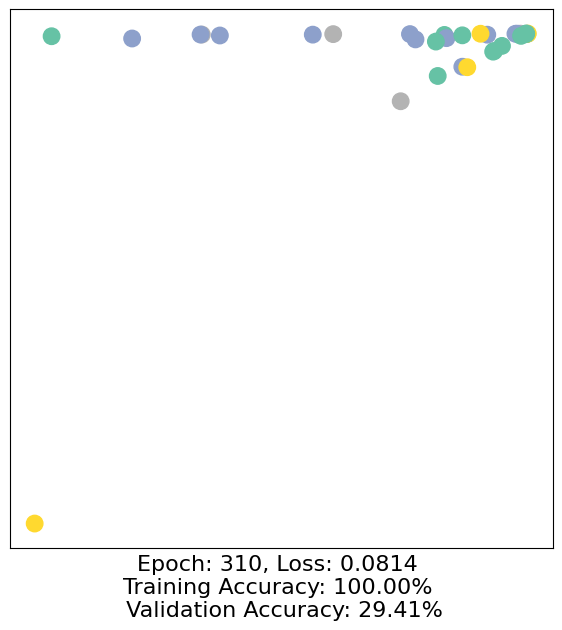

tensor(0.0631, grad_fn=<NllLossBackward0>)
tensor(0.6040, grad_fn=<NllLossBackward0>)
tensor(0.0764, grad_fn=<NllLossBackward0>)
tensor(0.0521, grad_fn=<NllLossBackward0>)
tensor(0.0562, grad_fn=<NllLossBackward0>)
tensor(0.0588, grad_fn=<NllLossBackward0>)
tensor(0.0547, grad_fn=<NllLossBackward0>)
tensor(0.0735, grad_fn=<NllLossBackward0>)
tensor(0.1348, grad_fn=<NllLossBackward0>)
tensor(0.0519, grad_fn=<NllLossBackward0>)


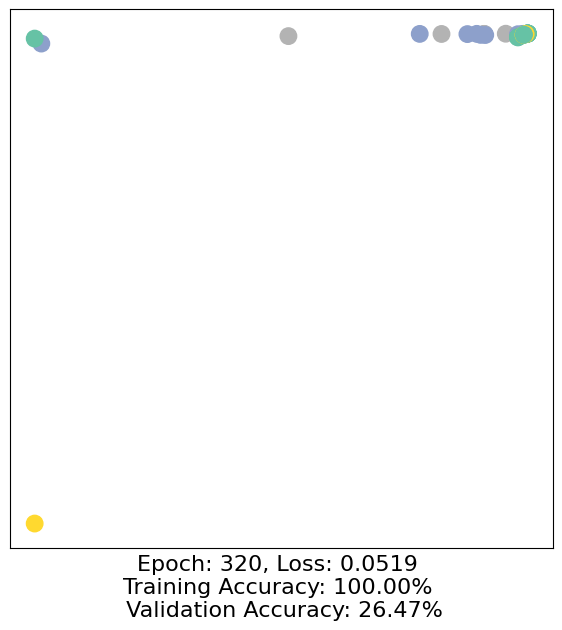

tensor(0.0481, grad_fn=<NllLossBackward0>)
tensor(0.3105, grad_fn=<NllLossBackward0>)
tensor(0.0522, grad_fn=<NllLossBackward0>)
tensor(0.0563, grad_fn=<NllLossBackward0>)
tensor(0.0915, grad_fn=<NllLossBackward0>)
tensor(0.0782, grad_fn=<NllLossBackward0>)
tensor(0.0465, grad_fn=<NllLossBackward0>)
tensor(0.0615, grad_fn=<NllLossBackward0>)
tensor(0.0642, grad_fn=<NllLossBackward0>)
tensor(0.0479, grad_fn=<NllLossBackward0>)


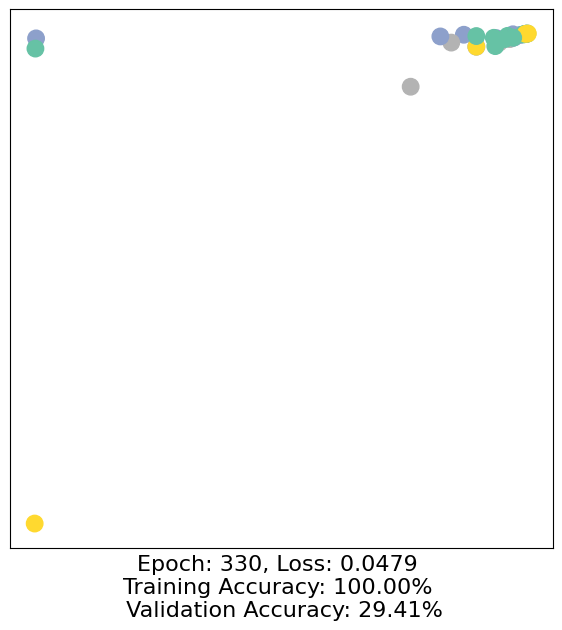

tensor(0.0476, grad_fn=<NllLossBackward0>)
tensor(0.0515, grad_fn=<NllLossBackward0>)
tensor(0.0564, grad_fn=<NllLossBackward0>)
tensor(0.0487, grad_fn=<NllLossBackward0>)
tensor(0.0445, grad_fn=<NllLossBackward0>)
tensor(0.0962, grad_fn=<NllLossBackward0>)
tensor(0.1717, grad_fn=<NllLossBackward0>)
tensor(0.0502, grad_fn=<NllLossBackward0>)
tensor(0.0450, grad_fn=<NllLossBackward0>)
tensor(0.1360, grad_fn=<NllLossBackward0>)


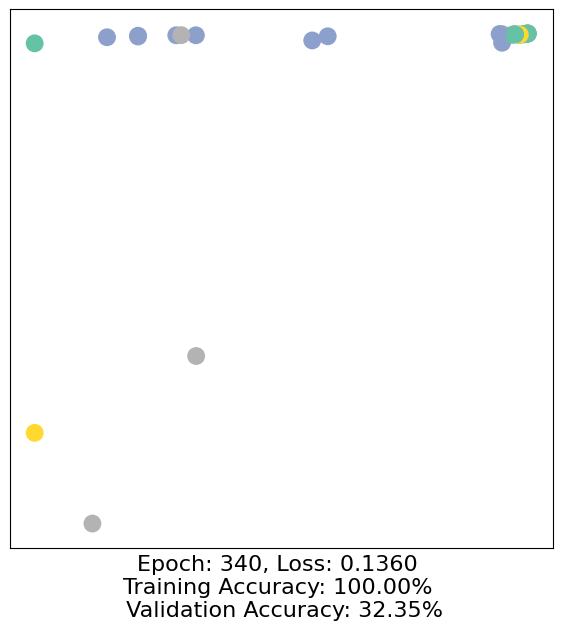

tensor(0.0500, grad_fn=<NllLossBackward0>)
tensor(0.5640, grad_fn=<NllLossBackward0>)
tensor(0.1085, grad_fn=<NllLossBackward0>)
tensor(0.0528, grad_fn=<NllLossBackward0>)
tensor(0.0953, grad_fn=<NllLossBackward0>)
tensor(0.0496, grad_fn=<NllLossBackward0>)
tensor(0.1460, grad_fn=<NllLossBackward0>)
tensor(0.0539, grad_fn=<NllLossBackward0>)
tensor(0.0589, grad_fn=<NllLossBackward0>)
tensor(0.0451, grad_fn=<NllLossBackward0>)


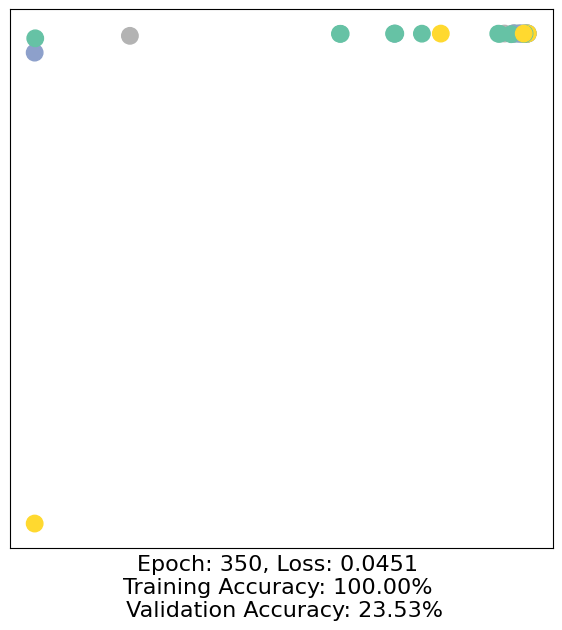

tensor(0.0407, grad_fn=<NllLossBackward0>)
tensor(0.0465, grad_fn=<NllLossBackward0>)
tensor(0.0421, grad_fn=<NllLossBackward0>)
tensor(0.0454, grad_fn=<NllLossBackward0>)
tensor(0.0414, grad_fn=<NllLossBackward0>)
tensor(0.0427, grad_fn=<NllLossBackward0>)
tensor(0.0398, grad_fn=<NllLossBackward0>)
tensor(0.0560, grad_fn=<NllLossBackward0>)
tensor(0.1008, grad_fn=<NllLossBackward0>)
tensor(0.0474, grad_fn=<NllLossBackward0>)


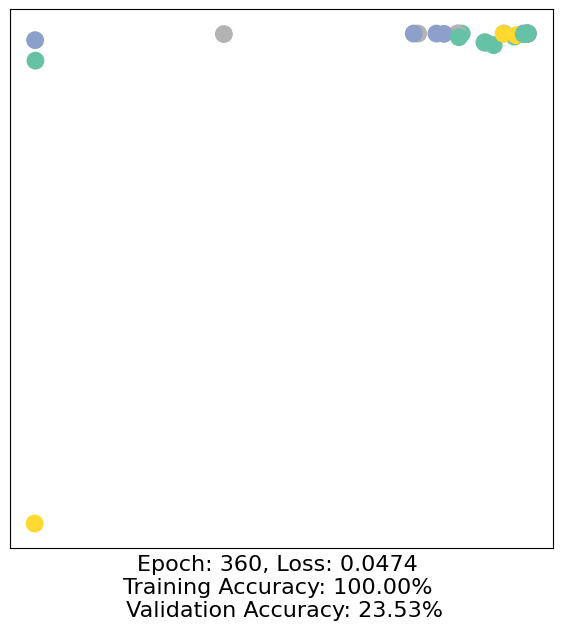

tensor(0.2122, grad_fn=<NllLossBackward0>)
tensor(0.0426, grad_fn=<NllLossBackward0>)
tensor(0.0388, grad_fn=<NllLossBackward0>)
tensor(0.0409, grad_fn=<NllLossBackward0>)
tensor(0.0432, grad_fn=<NllLossBackward0>)
tensor(0.0412, grad_fn=<NllLossBackward0>)
tensor(0.2691, grad_fn=<NllLossBackward0>)
tensor(0.0566, grad_fn=<NllLossBackward0>)
tensor(0.0477, grad_fn=<NllLossBackward0>)
tensor(0.0446, grad_fn=<NllLossBackward0>)


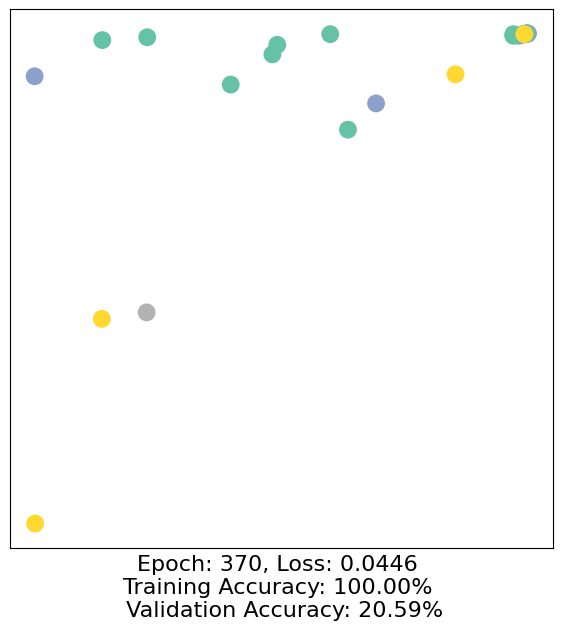

tensor(0.0441, grad_fn=<NllLossBackward0>)
tensor(0.3200, grad_fn=<NllLossBackward0>)
tensor(0.0354, grad_fn=<NllLossBackward0>)
tensor(0.0374, grad_fn=<NllLossBackward0>)
tensor(0.0387, grad_fn=<NllLossBackward0>)
tensor(0.2439, grad_fn=<NllLossBackward0>)
tensor(0.0431, grad_fn=<NllLossBackward0>)
tensor(0.0412, grad_fn=<NllLossBackward0>)
tensor(0.0753, grad_fn=<NllLossBackward0>)
tensor(0.0438, grad_fn=<NllLossBackward0>)


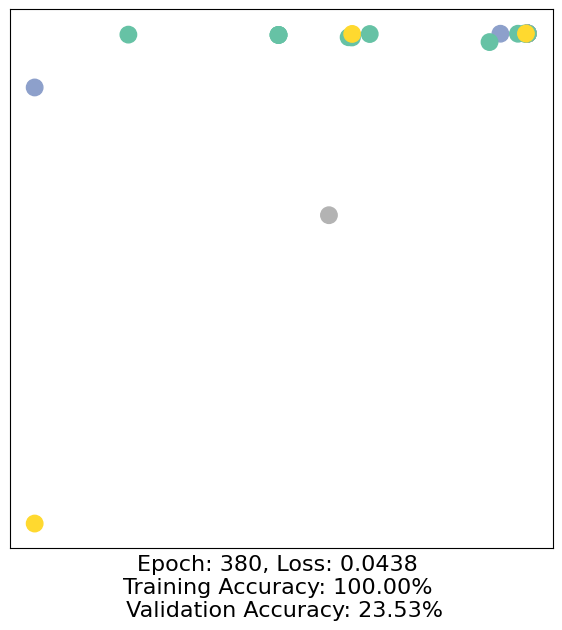

tensor(0.5680, grad_fn=<NllLossBackward0>)
tensor(0.0383, grad_fn=<NllLossBackward0>)
tensor(0.0370, grad_fn=<NllLossBackward0>)
tensor(0.0403, grad_fn=<NllLossBackward0>)
tensor(0.8342, grad_fn=<NllLossBackward0>)
tensor(0.0381, grad_fn=<NllLossBackward0>)
tensor(0.0355, grad_fn=<NllLossBackward0>)
tensor(0.0400, grad_fn=<NllLossBackward0>)
tensor(0.0396, grad_fn=<NllLossBackward0>)
tensor(0.0463, grad_fn=<NllLossBackward0>)


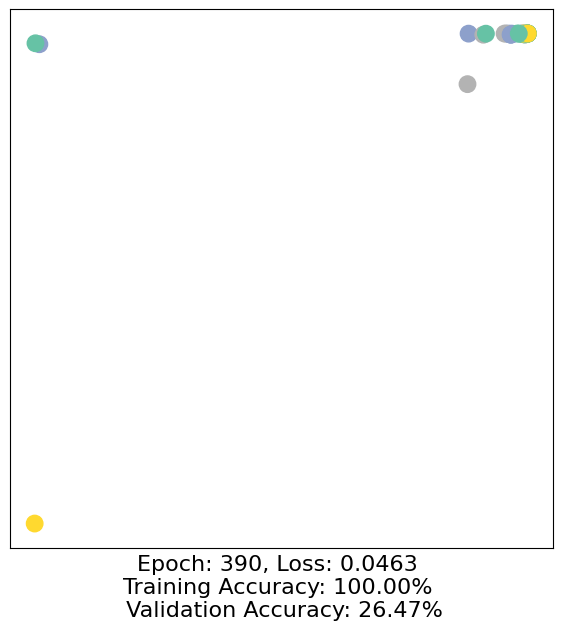

tensor(0.1064, grad_fn=<NllLossBackward0>)
tensor(0.0600, grad_fn=<NllLossBackward0>)
tensor(0.4776, grad_fn=<NllLossBackward0>)
tensor(0.0541, grad_fn=<NllLossBackward0>)
tensor(0.1878, grad_fn=<NllLossBackward0>)
tensor(0.0387, grad_fn=<NllLossBackward0>)
tensor(0.0381, grad_fn=<NllLossBackward0>)
tensor(0.0393, grad_fn=<NllLossBackward0>)
tensor(0.1324, grad_fn=<NllLossBackward0>)
tensor(0.0425, grad_fn=<NllLossBackward0>)


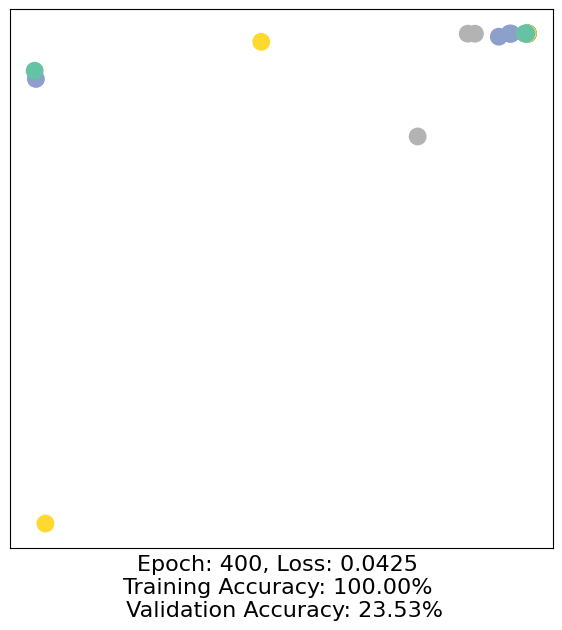

tensor(0.0376, grad_fn=<NllLossBackward0>)
tensor(0.0396, grad_fn=<NllLossBackward0>)
tensor(0.0377, grad_fn=<NllLossBackward0>)
tensor(0.0369, grad_fn=<NllLossBackward0>)
tensor(0.0333, grad_fn=<NllLossBackward0>)
tensor(0.0335, grad_fn=<NllLossBackward0>)
tensor(0.0424, grad_fn=<NllLossBackward0>)
tensor(0.0369, grad_fn=<NllLossBackward0>)
tensor(0.0348, grad_fn=<NllLossBackward0>)
tensor(0.0346, grad_fn=<NllLossBackward0>)


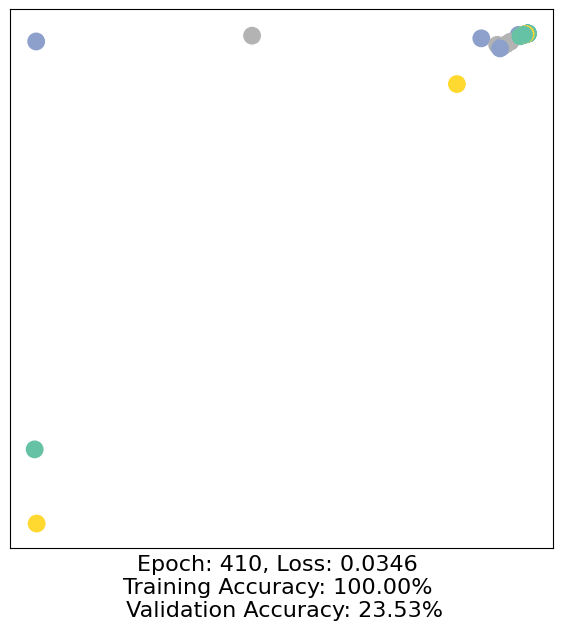

tensor(0.4391, grad_fn=<NllLossBackward0>)
tensor(0.0365, grad_fn=<NllLossBackward0>)
tensor(0.0357, grad_fn=<NllLossBackward0>)
tensor(0.1968, grad_fn=<NllLossBackward0>)
tensor(0.0342, grad_fn=<NllLossBackward0>)
tensor(0.0517, grad_fn=<NllLossBackward0>)
tensor(0.0366, grad_fn=<NllLossBackward0>)
tensor(0.0350, grad_fn=<NllLossBackward0>)
tensor(0.0391, grad_fn=<NllLossBackward0>)
tensor(0.0361, grad_fn=<NllLossBackward0>)


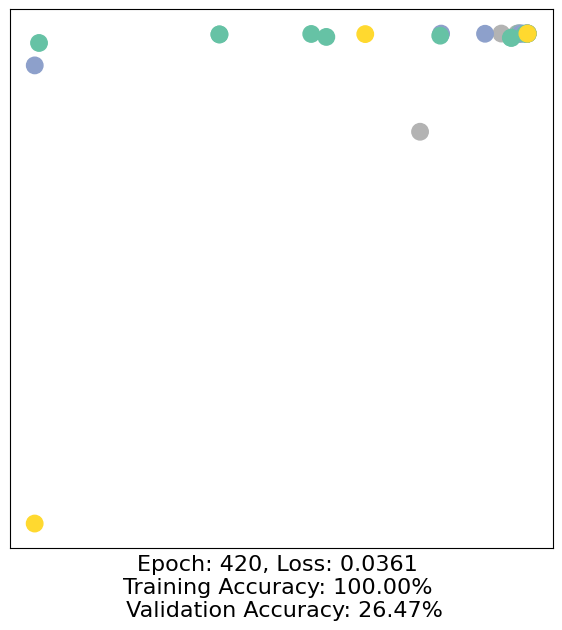

tensor(0.0330, grad_fn=<NllLossBackward0>)
tensor(0.0508, grad_fn=<NllLossBackward0>)
tensor(0.0334, grad_fn=<NllLossBackward0>)
tensor(0.0358, grad_fn=<NllLossBackward0>)
tensor(0.0284, grad_fn=<NllLossBackward0>)
tensor(0.0327, grad_fn=<NllLossBackward0>)
tensor(0.0313, grad_fn=<NllLossBackward0>)
tensor(0.0398, grad_fn=<NllLossBackward0>)
tensor(0.0285, grad_fn=<NllLossBackward0>)
tensor(0.1515, grad_fn=<NllLossBackward0>)


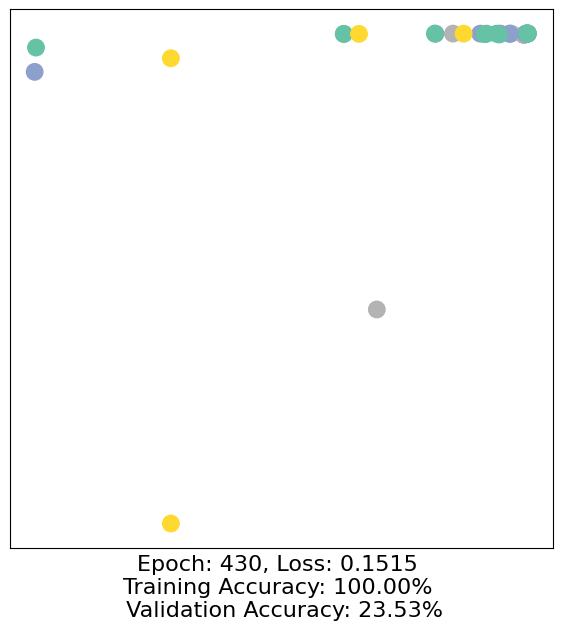

tensor(0.0323, grad_fn=<NllLossBackward0>)
tensor(0.0378, grad_fn=<NllLossBackward0>)
tensor(0.0364, grad_fn=<NllLossBackward0>)
tensor(0.0613, grad_fn=<NllLossBackward0>)
tensor(0.0417, grad_fn=<NllLossBackward0>)
tensor(0.0310, grad_fn=<NllLossBackward0>)
tensor(0.0731, grad_fn=<NllLossBackward0>)
tensor(0.0288, grad_fn=<NllLossBackward0>)
tensor(0.0652, grad_fn=<NllLossBackward0>)
tensor(0.0772, grad_fn=<NllLossBackward0>)


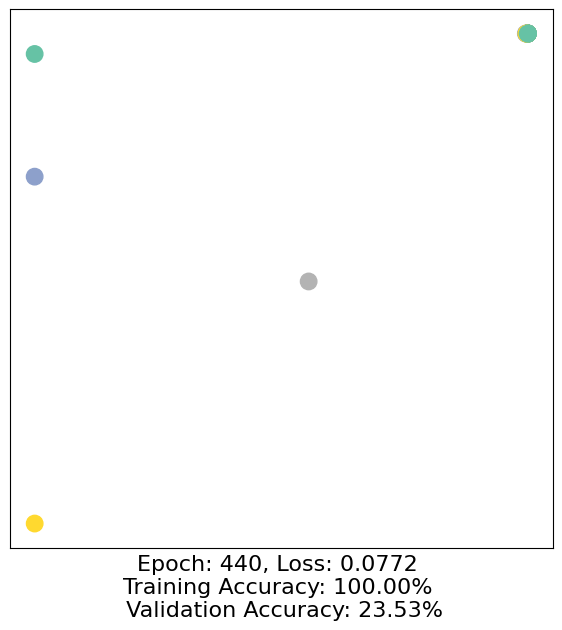

tensor(0.0287, grad_fn=<NllLossBackward0>)
tensor(0.0286, grad_fn=<NllLossBackward0>)
tensor(0.1132, grad_fn=<NllLossBackward0>)
tensor(0.0495, grad_fn=<NllLossBackward0>)
tensor(0.7177, grad_fn=<NllLossBackward0>)
tensor(0.0302, grad_fn=<NllLossBackward0>)
tensor(0.0274, grad_fn=<NllLossBackward0>)
tensor(0.0274, grad_fn=<NllLossBackward0>)
tensor(0.0296, grad_fn=<NllLossBackward0>)
tensor(0.0388, grad_fn=<NllLossBackward0>)


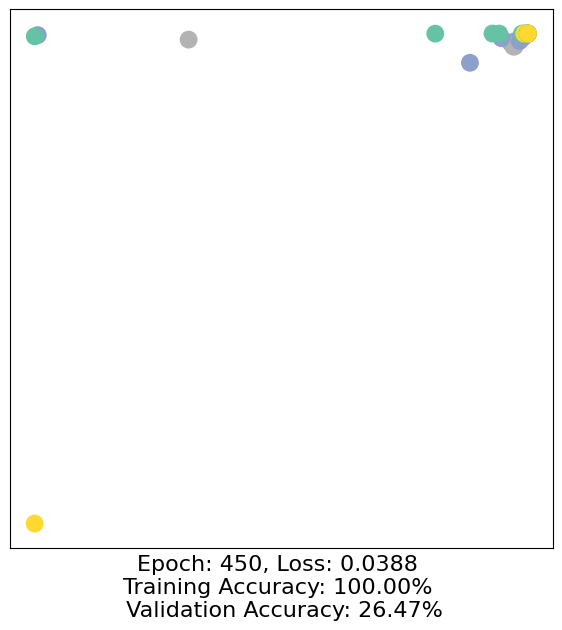

tensor(0.1045, grad_fn=<NllLossBackward0>)
tensor(0.0259, grad_fn=<NllLossBackward0>)
tensor(0.6891, grad_fn=<NllLossBackward0>)
tensor(0.0538, grad_fn=<NllLossBackward0>)
tensor(0.0294, grad_fn=<NllLossBackward0>)
tensor(0.0741, grad_fn=<NllLossBackward0>)
tensor(0.0304, grad_fn=<NllLossBackward0>)
tensor(0.0284, grad_fn=<NllLossBackward0>)
tensor(0.4149, grad_fn=<NllLossBackward0>)
tensor(0.0477, grad_fn=<NllLossBackward0>)


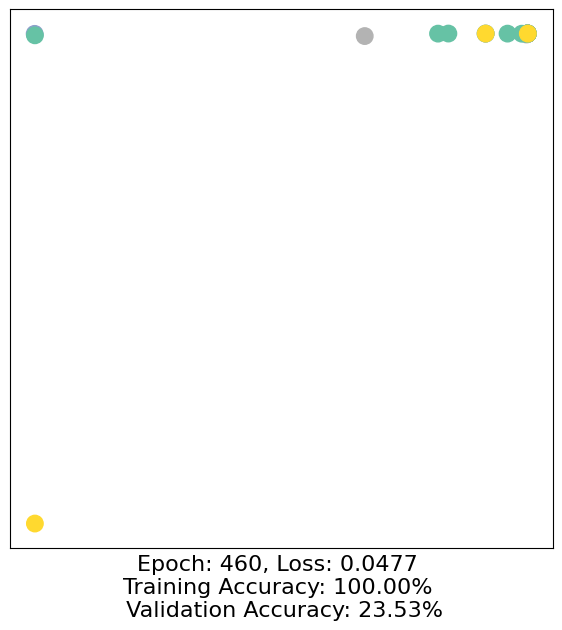

tensor(0.0645, grad_fn=<NllLossBackward0>)
tensor(0.0271, grad_fn=<NllLossBackward0>)
tensor(0.6731, grad_fn=<NllLossBackward0>)
tensor(0.0268, grad_fn=<NllLossBackward0>)
tensor(0.0257, grad_fn=<NllLossBackward0>)
tensor(0.0900, grad_fn=<NllLossBackward0>)
tensor(0.0243, grad_fn=<NllLossBackward0>)
tensor(0.0244, grad_fn=<NllLossBackward0>)
tensor(0.0265, grad_fn=<NllLossBackward0>)
tensor(0.0282, grad_fn=<NllLossBackward0>)


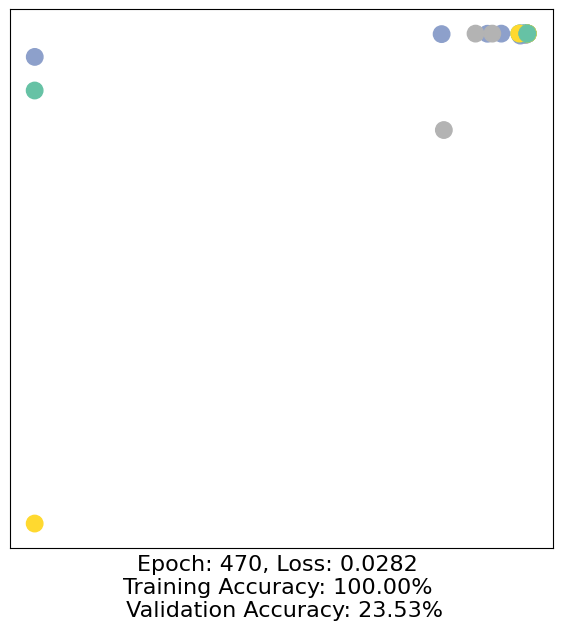

tensor(0.0249, grad_fn=<NllLossBackward0>)
tensor(0.2060, grad_fn=<NllLossBackward0>)
tensor(0.0241, grad_fn=<NllLossBackward0>)
tensor(0.2623, grad_fn=<NllLossBackward0>)
tensor(0.0258, grad_fn=<NllLossBackward0>)
tensor(0.0757, grad_fn=<NllLossBackward0>)
tensor(0.0360, grad_fn=<NllLossBackward0>)
tensor(0.1972, grad_fn=<NllLossBackward0>)
tensor(0.0309, grad_fn=<NllLossBackward0>)
tensor(0.0296, grad_fn=<NllLossBackward0>)


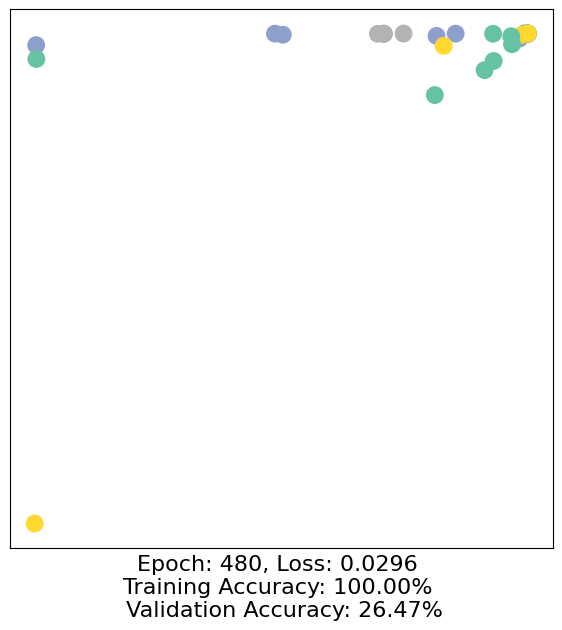

tensor(0.0338, grad_fn=<NllLossBackward0>)
tensor(0.0247, grad_fn=<NllLossBackward0>)
tensor(0.0232, grad_fn=<NllLossBackward0>)
tensor(0.2156, grad_fn=<NllLossBackward0>)
tensor(0.0412, grad_fn=<NllLossBackward0>)
tensor(0.0738, grad_fn=<NllLossBackward0>)
tensor(0.0323, grad_fn=<NllLossBackward0>)
tensor(0.0238, grad_fn=<NllLossBackward0>)
tensor(0.5146, grad_fn=<NllLossBackward0>)
tensor(0.0231, grad_fn=<NllLossBackward0>)


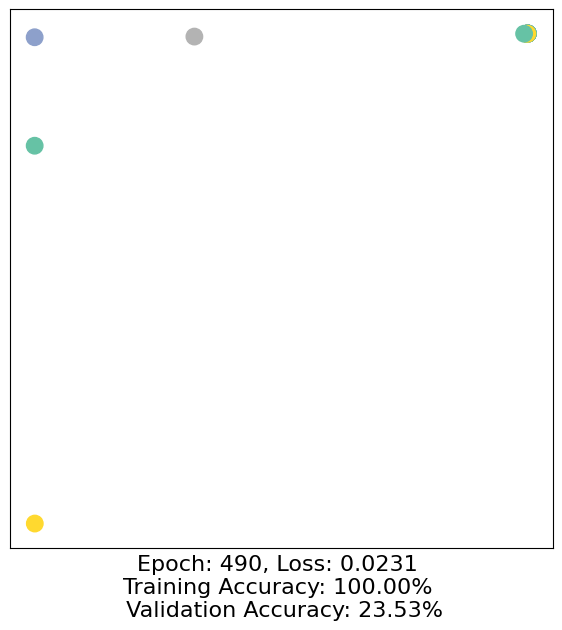

tensor(0.0273, grad_fn=<NllLossBackward0>)
tensor(0.0260, grad_fn=<NllLossBackward0>)
tensor(0.0235, grad_fn=<NllLossBackward0>)
tensor(0.1766, grad_fn=<NllLossBackward0>)
tensor(0.0240, grad_fn=<NllLossBackward0>)
tensor(0.0231, grad_fn=<NllLossBackward0>)
tensor(0.0257, grad_fn=<NllLossBackward0>)
tensor(0.0274, grad_fn=<NllLossBackward0>)
tensor(0.0264, grad_fn=<NllLossBackward0>)


In [31]:
import time


model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}
    # Calculate training accuracy on our four examples
    predicted_classes = torch.argmax(out[data.train_mask], axis=1) # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())
    
    # Calculate validation accuracy on the whole graph
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    return loss, h, accuracy

for epoch in range(500):
    loss, h, accuracy = train(data)
    print(loss)
    # Visualize the node embeddings every 10 epochs
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        time.sleep(0.3)

As one can see, our 3-layer GCN model manages to separate the communities pretty well and classify most of the nodes correctly.

Furthermore, we did this all with a few lines of code, thanks to the PyTorch Geometric library which helped us out with data handling and GNN implementations.


## Documentation



You can explore more PyG functions through its [documentation](https://pytorch-geometric.readthedocs.io/en/latest/).